> #### **Project Title**
- Energy Load Forecasting for Smart Zone Management using Weather Data



> #### **Project Objective**
- To build a regression model that predicts energy load in each zone (Zone 1, Zone 2, Zone 3) based on environmental factors such as temperature, humidity, wind speed, and diffuse solar flows.

> #### **Business Goal**
To optimize energy distribution and planning by forecasting future power demands in different zones. This will:
- Help reduce energy wastage.
- Improve load balancing across the zones.
- Support decision-making for renewable energy integration.
- Enhance efficiency in smart grid systems or building energy management.

> #### **1. Import Libraries**

In [94]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [95]:
df = pd.read_csv("power_consumption.csv")
df.head(2)

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1,Zone 2,Zone 3
0,01-01-2017 00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,01-01-2017 00:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434


In [96]:
df.shape

(52416, 9)

### Dataset Description
- **Rows:** 52,416
- **Columns:**  9
- **Target Variable:** `Zone 1`, `Zone 2`, `Zone 3` =>  These are the values the model will predict.
- **Prediction Task:** Given the environmental features (Temperature, Humidity, Wind Speed, Solar Flows), predict the energy load for each zone. It can also be treated as three separate regression problems, one for each zone.
- but in this project we only use one target feature like `Zone 1`

> #### **2. Feature Engineering**

In [97]:
df['DateTime'].isnull().sum()

np.int64(0)

In [98]:
df['DateTime'].unique()

array(['01-01-2017 00:00', '01-01-2017 00:10', '01-01-2017 00:20', ...,
       '12/30/2017 23:30', '12/30/2017 23:40', '12/30/2017 23:50'],
      shape=(52416,), dtype=object)

In [99]:
import re
from collections import Counter

def check_format(date_str):
    if re.match(r'^\d{1,2}-\d{1,2}-\d{4}', date_str):
        return 'DD-MM-YYYY'
    elif re.match(r'^\d{1,2}/\d{1,2}/\d{4}', date_str):
        return 'MM/DD/YYYY'
    else:
        return 'Unknown'

format_counts = df['DateTime'].astype(str).apply(check_format)
print(format_counts.value_counts())


DateTime
MM/DD/YYYY    31680
DD-MM-YYYY    20736
Name: count, dtype: int64


In [100]:
import pandas as pd

# Step 1: Identify formats
mmdd_mask = df['DateTime'].str.contains('/')
ddmm_mask = df['DateTime'].str.contains('-')

# Step 2: Split data
df_mmdd = df[mmdd_mask].copy()
df_ddmm = df[ddmm_mask].copy()



In [101]:
# Convert MM/DD/YYYY
df_mmdd['DateTime'] = pd.to_datetime(df_mmdd['DateTime'], format='%m/%d/%Y %H:%M', errors='coerce')
# Convert DD-MM-YYYY
df_ddmm['DateTime'] = pd.to_datetime(df_ddmm['DateTime'], format='%d-%m-%Y %H:%M', errors='coerce')


In [102]:
# Combine both cleaned DataFrames
df_cleaned = pd.concat([df_mmdd, df_ddmm]).sort_values('DateTime').reset_index(drop=True)


In [103]:
print(df_cleaned['DateTime'].isna().sum()) 


0


In [104]:
df_cleaned['hour'] = df_cleaned['DateTime'].dt.hour
df_cleaned['dayofweek'] = df_cleaned['DateTime'].dt.dayofweek
df_cleaned['month'] = df_cleaned['DateTime'].dt.month
df_cleaned['is_weekend'] = df_cleaned['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)


In [105]:
df_cleaned.drop(columns="DateTime", inplace=True)

In [106]:
df_cleaned.shape

(52416, 12)

In [107]:
print(df.columns.tolist())

['DateTime', 'Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows', 'diffuse flows', 'Zone 1', 'Zone 2  ', 'Zone 3  ']


In [108]:
df_cleaned.drop(columns=['Zone 2  ', 'Zone 3  '], inplace= True, axis=1)

In [109]:
df_cleaned.head(2)

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1,hour,dayofweek,month,is_weekend
0,6.559,73.8,0.083,0.051,0.119,34055.69620,0,6,1,1
1,6.414,74.5,0.083,0.070,0.085,29814.68354,0,6,1,1


In [110]:
df_cleaned.shape

(52416, 10)

> #### **3. Data Preprocessing**

##### **3.1: Data Cleaning**

In [111]:
df_cleaned.isnull().sum() # our data have no null values

Temperature              0
Humidity                 0
Wind Speed               0
general diffuse flows    0
diffuse flows            0
Zone 1                   0
hour                     0
dayofweek                0
month                    0
is_weekend               0
dtype: int64

##### **3.2 Handle Duplicates**

In [112]:
duplicates = df_cleaned.duplicated().sum()
duplicates

np.int64(0)

##### **3.3: Data Inconsistencies and Errors**

In [113]:
df_cleaned.dtypes

Temperature              float64
Humidity                 float64
Wind Speed               float64
general diffuse flows    float64
diffuse flows            float64
Zone 1                   float64
hour                       int32
dayofweek                  int32
month                      int32
is_weekend                 int64
dtype: object

> ##### **3.4: ENCODING**
- Our data is encoded

> ##### **3.5: Handling Outliers**

In [114]:
# Calculate outlier percentage for all features in the dataset using IQR method
def calculate_outlier_percentages(df_cleaned):
    outlier_percentages = {}
    for col in df_cleaned.columns:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df_cleaned[(df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)][col]
        outlier_percentages[col] = len(outliers) / len(df_cleaned) * 100  # Percentage of outliers
    return outlier_percentages

outlier_percentages_all = calculate_outlier_percentages(df_cleaned)
outlier_percentages_all

{'Temperature': 0.2709096459096459,
 'Humidity': 0.5551739926739927,
 'Wind Speed': 0.0,
 'general diffuse flows': 4.416590354090355,
 'diffuse flows': 8.720619658119658,
 'Zone 1': 0.0,
 'hour': 0.0,
 'dayofweek': 0.0,
 'month': 0.0,
 'is_weekend': 0.0}

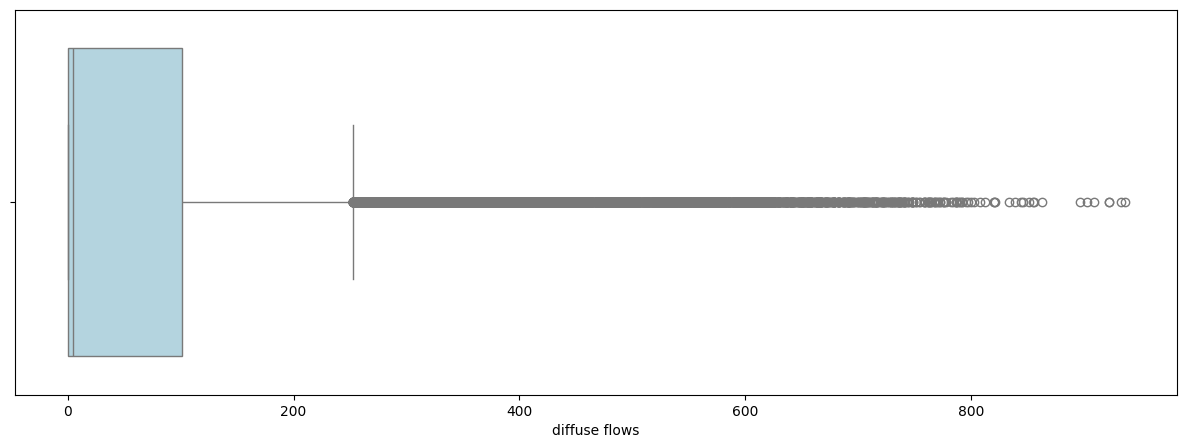

In [115]:
# one by one apply on 2 features
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,5))
sns.boxplot(x= "diffuse flows",data= df_cleaned, color='lightblue')
plt.show()

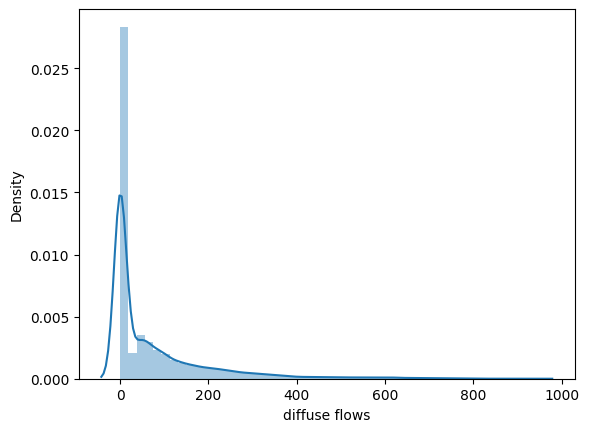

In [116]:
sns.distplot(df_cleaned["diffuse flows"])
plt.show()

In [117]:
# before removing outliers on feature `diffuse flows`  
#      'general diffuse flows': 4.416590354090355,
#      'diffuse flows': 8.720619658119658,
# after removing outliers on feature `diffuse flows`
#       'general diffuse flows': 13.309645731006375,
#       'diffuse flows': 6.1093113177970535, 
# so the solution is don’t clean one feature at a time

- so we need to use a combined strategy to detect and clean outliers across all important features at once.
- This prevents one feature’s cleaning from negatively impacting others.

In [118]:
copy1 = df_cleaned.copy()

In [119]:
features = ['Temperature', 'Humidity', 'diffuse flows', 'general diffuse flows']
combined_mask = np.zeros(len(copy1), dtype=bool)

for col in features:
    Q1 = copy1[col].quantile(0.25)
    Q3 = copy1[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    combined_mask |= (copy1[col] < lower) | (copy1[col] > upper)

data = copy1[~combined_mask]


In [120]:
data.head(2)

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1,hour,dayofweek,month,is_weekend
0,6.559,73.8,0.083,0.051,0.119,34055.69620,0,6,1,1
1,6.414,74.5,0.083,0.070,0.085,29814.68354,0,6,1,1


In [121]:
# Calculate outlier percentage for all features in the dataset using IQR method
def calculate_outlier_percentages(data):
    outlier_percentages = {}
    for col in data.columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)][col]
        outlier_percentages[col] = len(outliers) / len(data) * 100  # Percentage of outliers
    return outlier_percentages

outlier_percentages_all = calculate_outlier_percentages(data)
outlier_percentages_all

{'Temperature': 0.14508045370614614,
 'Humidity': 0.23300800140684075,
 'Wind Speed': 0.0,
 'general diffuse flows': 13.516662270289281,
 'diffuse flows': 7.6255165743427415,
 'Zone 1': 0.0,
 'hour': 0.0,
 'dayofweek': 0.0,
 'month': 0.0,
 'is_weekend': 0.0}

In [122]:
data.shape

(45492, 10)

- Again the result is same. so we work and assume that outlier is low and we handle this on scaling.
- and because the outliers is below than 8%. so it considerable.

In [ ]:
# df_cleaned.to_csv('cleaned_power_consumption.csv', index=False)

> #### **Import Cleaned File**

In [124]:
DATA = pd.read_csv("cleaned_power_consumption.csv")

In [133]:
DATA.shape

(52416, 10)

In [134]:
DATA.head(2)

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1,hour,dayofweek,month,is_weekend
0,6.559,73.8,0.083,0.051,0.119,34055.69620,0,6,1,1
1,6.414,74.5,0.083,0.070,0.085,29814.68354,0,6,1,1


> ##### **3.6: EDA Visualization**

- **Check data linear or non limear**

In [135]:
visual_data = DATA.copy()

In [136]:
visual_data.shape

(52416, 10)

In [137]:
print(visual_data.columns.tolist())

['Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows', 'diffuse flows', 'Zone 1', 'hour', 'dayofweek', 'month', 'is_weekend']


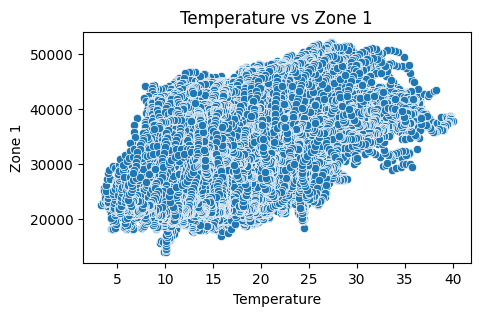

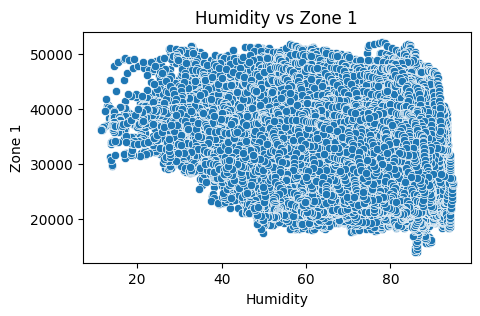

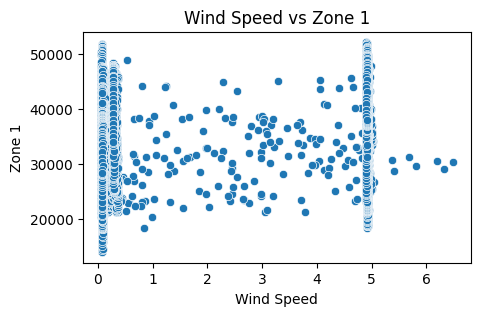

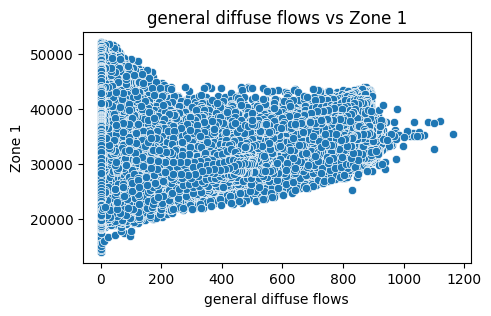

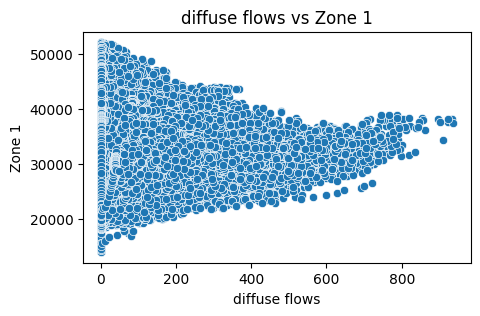

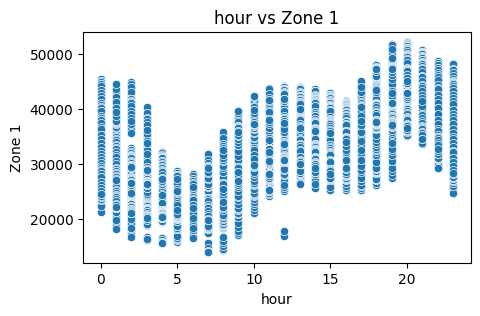

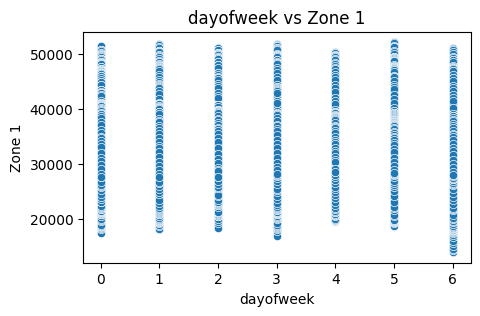

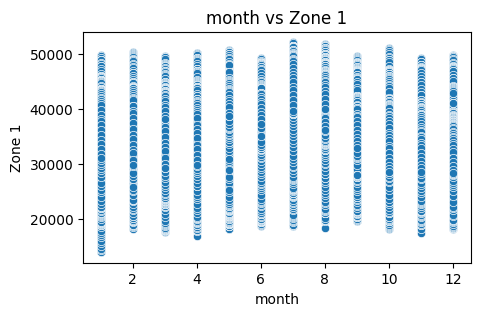

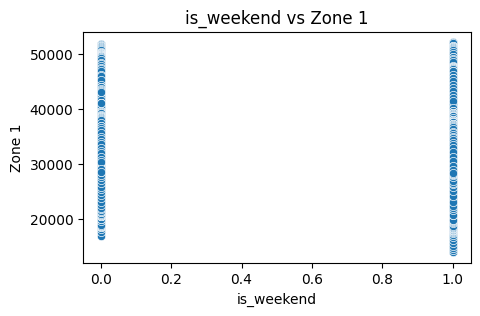

In [138]:
# Plot each feature against the target
import matplotlib.pyplot as plt
import seaborn as sns

features = ['Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows', 'diffuse flows', 'hour', 'dayofweek', 'month', 'is_weekend']
target = 'Zone 1' 

for col in features:
    plt.figure(figsize=(5, 3))
    sns.scatterplot(x=visual_data[col], y=visual_data[target])
    plt.title(f"{col} vs {target}")
    plt.show()

In [139]:
print(visual_data[features + ['Zone 1']].corr()['Zone 1'].sort_values())
# but .corr() is use for linear relationship


Humidity                -0.287421
is_weekend              -0.042285
dayofweek               -0.034443
month                    0.007736
diffuse flows            0.080274
Wind Speed               0.167444
general diffuse flows    0.187965
Temperature              0.440221
hour                     0.727953
Zone 1                   1.000000
Name: Zone 1, dtype: float64


| Correlation Value | Meaning                      |
| ----------------- | ---------------------------- |
| > 0.7 or < -0.7   | Strong linear relationship  |
| 0.3 to 0.7        | Moderate linear              |
| < 0.3             | Likely nonlinear or weak     |

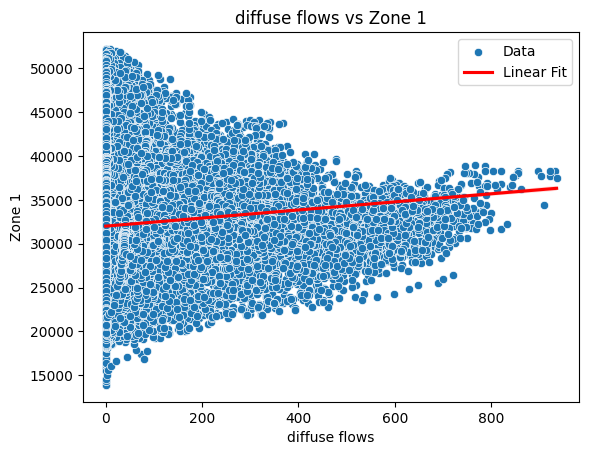

In [149]:
# scatter plot is the simplist and best ways to ckeck linear and non linear.
# set feature one by one
sns.scatterplot(x=visual_data['diffuse flows'], y=visual_data['Zone 1'], label='Data')
sns.regplot(x='diffuse flows', y='Zone 1', data=visual_data, scatter=False, color='red', label='Linear Fit')
plt.title('diffuse flows vs Zone 1')
plt.legend()
plt.show()


| Shape/Pattern  | Meaning           | Action                           |
| -------------- | ----------------- | -------------------------------- |
| Straight line  | Linear           | Good for linear regression       |
| Curve or bowl  | Nonlinear        | Use tree-based or transform data |
| Random scatter | No relationship  | Likely drop or ignore feature    |


> ##### Univariate Analysis

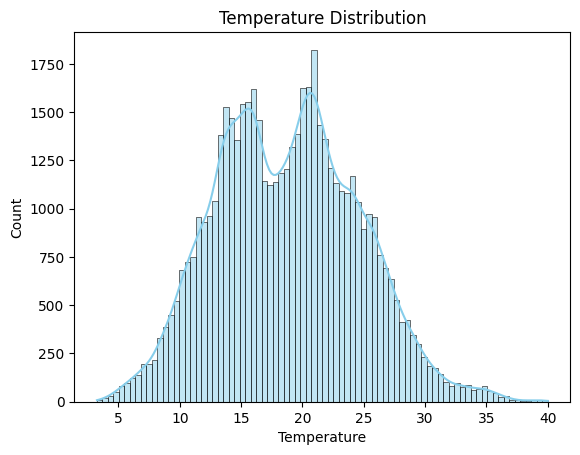

In [ ]:
# Distribution Plot --  Temperature
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=visual_data, x='Temperature', kde=True, color='skyblue')
plt.title('Temperature Distribution')
plt.show()


- Shows how temperature values are spread (normal, skewed, etc.)
- Detects outliers or skewness and can tell if temperature is normally distributed.

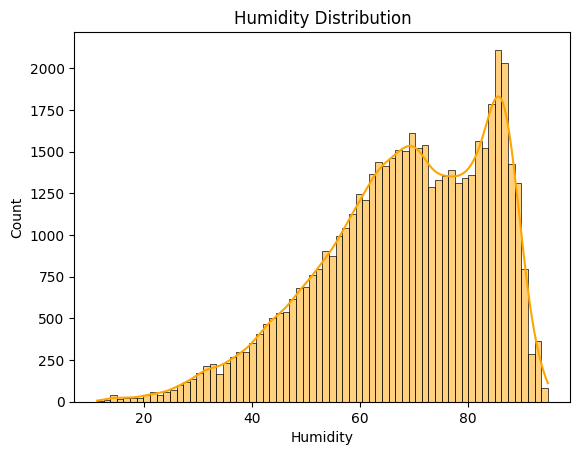

In [ ]:
# Distribution Plot – Humidity
sns.histplot(data=visual_data, x='Humidity', kde=True, color='orange')
plt.title('Humidity Distribution')
plt.show()


- we can detect whether values cluster (e.g., most days are humid or dry) and helps in transformations (log scale if skewed)

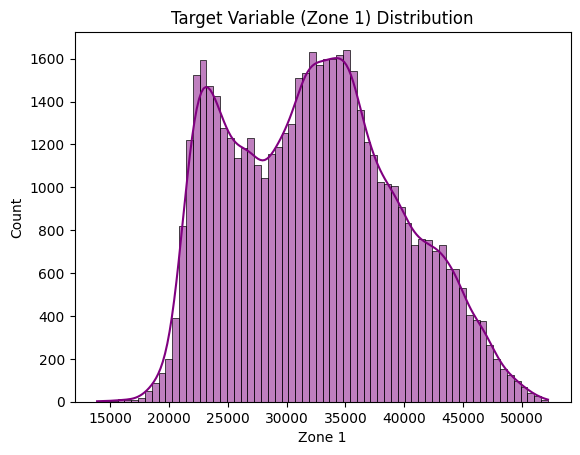

In [ ]:
# Histogram – Zone 1
sns.histplot(data=visual_data, x='Zone 1', kde=True, color='purple')
plt.title('Target Variable (Zone 1) Distribution')
plt.show()


- in this we checks if regression target is skewed.
- Helps decide whether log-transform is needed.

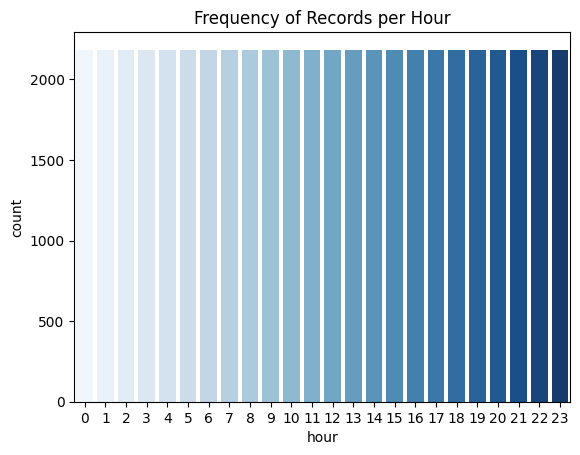

In [ ]:
#  Count Plot – Hour
sns.countplot(data=visual_data, x='hour', palette='Blues')
plt.title('Frequency of Records per Hour')
plt.show()


- it shows which hours are most active (e.g., peak usage times)
- it good for time-based modeling

> #### Bivariate Analysis

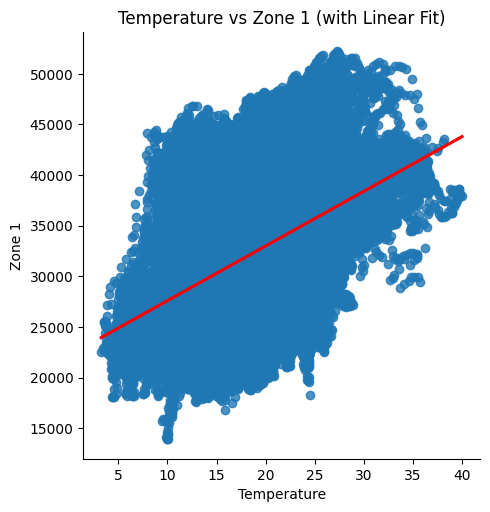

In [ ]:
# Temperature vs Zone 1 (Scatter + Line Fit)
sns.lmplot(data=visual_data, x='Temperature', y='Zone 1', line_kws={'color': 'red'})
plt.title('Temperature vs Zone 1 (with Linear Fit)')
plt.show()


- Shows if temperature increases or decreases energy usage
- Trend line helps visualize linear/non-linear patterns

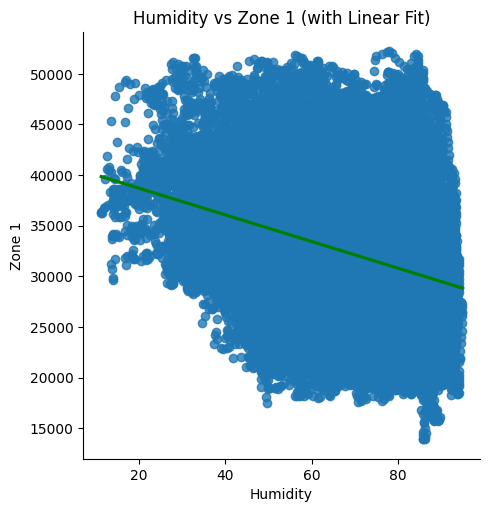

In [ ]:
# Humidity vs Zone 1
sns.lmplot(data=visual_data, x='Humidity', y='Zone 1', line_kws={'color': 'green'})
plt.title('Humidity vs Zone 1 (with Linear Fit)')
plt.show()


- Shows if higher humidity affects energy flow
- Check for positive/negative or no clear relationship

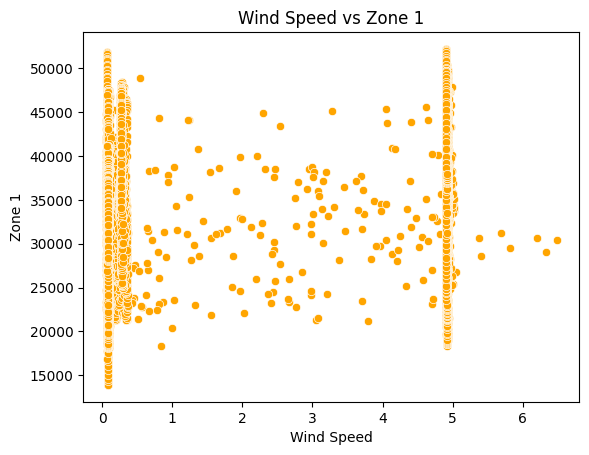

In [211]:
# Wind Speed vs Zone 1
sns.scatterplot(data=visual_data, x='Wind Speed', y='Zone 1', color='orange')
plt.title('Wind Speed vs Zone 1')
plt.show()


- it often shows no clear pattern (low importance)
- it confirms if it’s a weak feature

> #### Multivariate Analysis

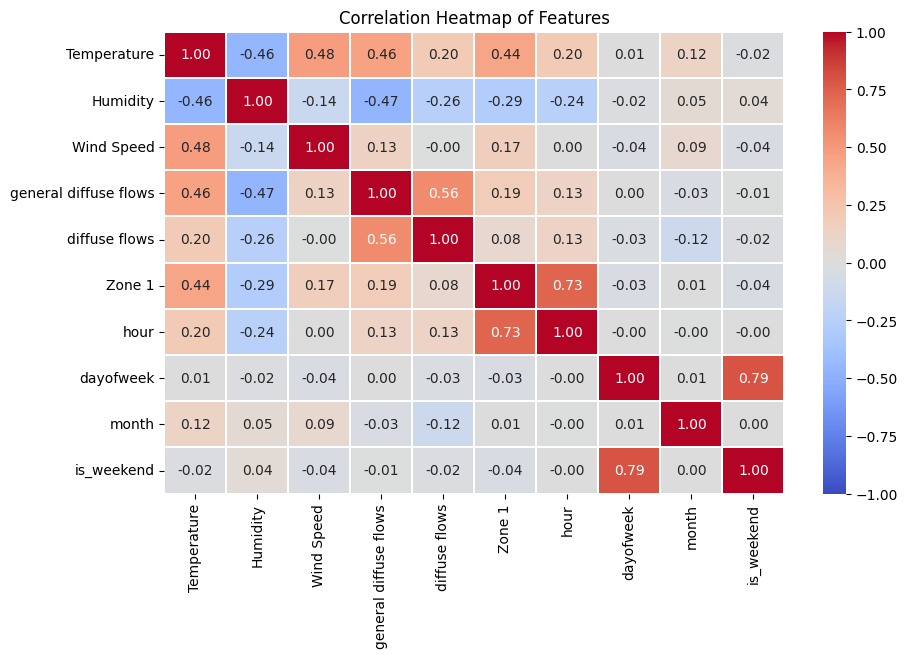

In [212]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(visual_data.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.3, vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Features')
plt.show()


- Correlation > 0.7 and correlation > - 0.7 → strong relationship
- it helps find multicollinearity

Exception ignored in: <function tqdm.__del__ at 0x0000017FE0730680>
Traceback (most recent call last):
  File "c:\Users\Mc\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\Mc\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x0000017FE0730680>
Traceback (most recent call last):
  File "c:\Users\Mc\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\Mc\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


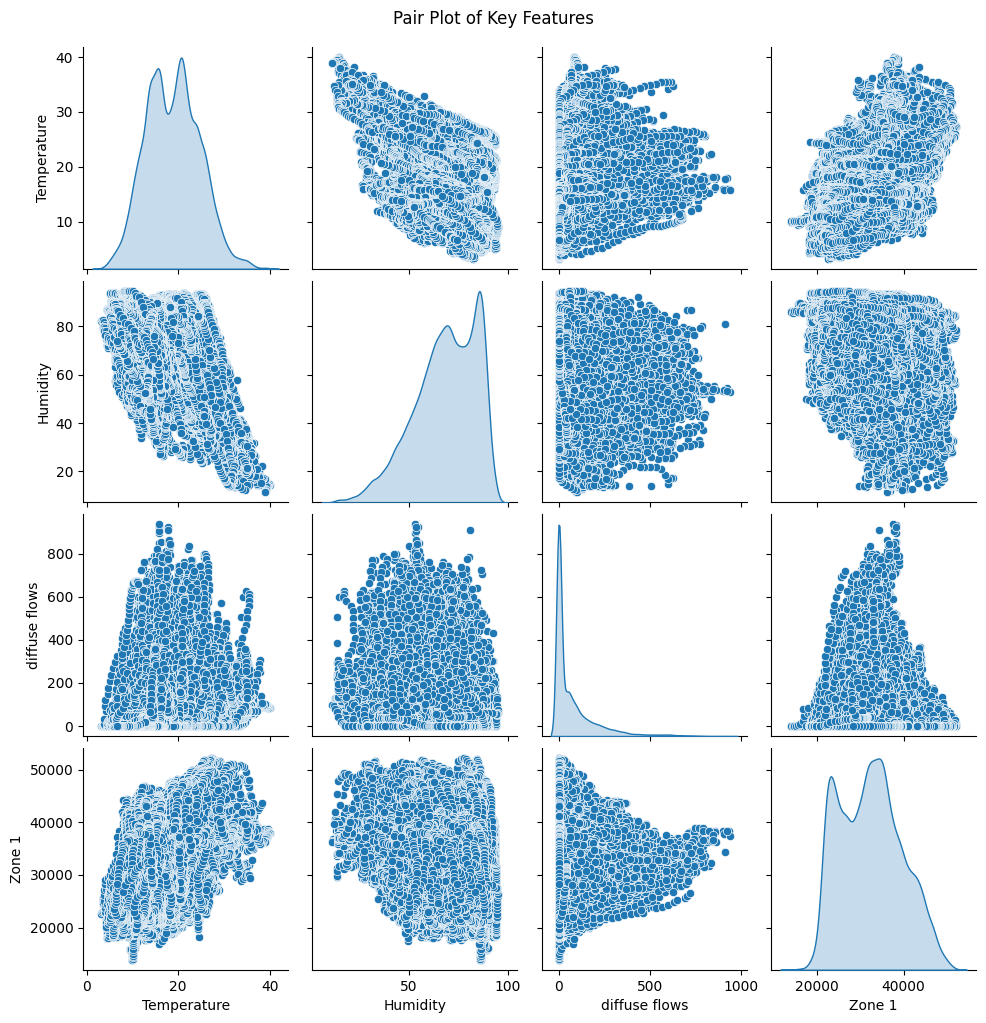

In [213]:
# Pair Plot (only key features)
sns.pairplot(visual_data[['Temperature', 'Humidity', 'diffuse flows', 'Zone 1']], diag_kind='kde')
plt.suptitle('Pair Plot of Key Features', y=1.02)
plt.show()


- Diagonal: feature distributions
- Off-diagonal: scatter relationships between each pair
- Shows combined patterns and outliers

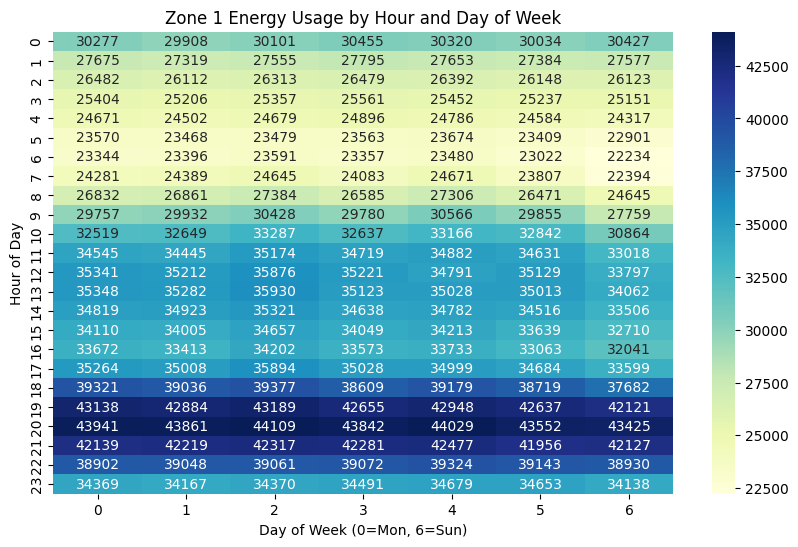

In [214]:
pivot = visual_data.pivot_table(index='hour', columns='dayofweek', values='Zone 1', aggfunc='mean')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap='YlGnBu', annot=True, fmt=".0f")
plt.title('Zone 1 Energy Usage by Hour and Day of Week')
plt.xlabel('Day of Week (0=Mon, 6=Sun)')
plt.ylabel('Hour of Day')
plt.show()


- Shows when (hour + weekday) energy usage is highest
- Perfect for identifying time-based trends

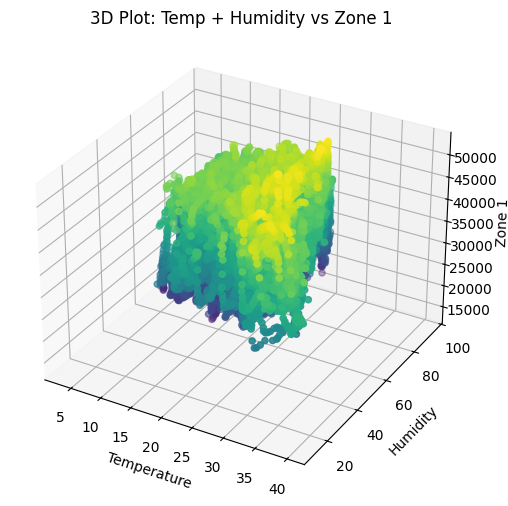

In [216]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    visual_data['Temperature'],
    visual_data['Humidity'],
    visual_data['Zone 1'],
    c=visual_data['Zone 1'], cmap='viridis'
)

ax.set_xlabel('Temperature')
ax.set_ylabel('Humidity')
ax.set_zlabel('Zone 1')
plt.title('3D Plot: Temp + Humidity vs Zone 1')
plt.show()


- See how 2 inputs together influence the target (Zone 1)
- Great for non-linear interaction visibility

> #### **4: SCALING**

In [150]:
x = DATA.drop(columns='Zone 1')
y = DATA['Zone 1']

In [151]:
x.shape

(52416, 9)

In [152]:
y.shape

(52416,)

In [156]:
from sklearn.preprocessing import StandardScaler
# Scaling the features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [157]:
# Ensure X remains a DataFrame
# x_scaled is need in dataframe because in correlation .corr is work with dataframe, and x_scaled is a numpay array.
x_final = pd.DataFrame(x_scaled, columns=data.drop(columns=['Zone 1']).columns)

In [158]:
x_final.head(2)

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,hour,dayofweek,month,is_weekend
0,-2.106645,0.356277,-0.7989,-0.690797,-0.603085,-1.661325,1.5,-1.601748,1.581139
1,-2.131578,0.401291,-0.7989,-0.690725,-0.603359,-1.661325,1.5,-1.601748,1.581139


In [159]:
x_final.shape

(52416, 9)

In [160]:
y.shape

(52416,)

> #### **5. Model Selection and Training**

In [161]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [162]:
x_train,x_test,y_train,y_test = train_test_split(x_final,y, test_size=0.20, random_state=42)

- **Linear Model**

In [163]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [168]:
lr.score(x_test, y_test)*100

63.543720644890996

In [169]:
lr.score(x_train, y_train)*100

62.86274473413533

In [166]:
y_pred = lr.predict(x_test)

In [167]:
# Assume y_test is true values and y_pred is your model's predictions
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.3f}")

Mean Squared Error (MSE): 18496972.53
Mean Absolute Error (MAE): 3413.37
R² Score: 0.635


- **Tree Model**

In [170]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
dtr.fit(x_train, y_train)

DecisionTreeRegressor()

In [171]:
dtr.score(x_test, y_test)*100

94.0822963308885

In [172]:
dtr.score(x_train, y_train)*100

100.0

- our model is slightly overfit

In [174]:
y_pred = dtr.predict(x_test)

In [175]:
# Assume y_test is true values and y_pred is your model's predictions
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.3f}")

Mean Squared Error (MSE): 3002489.67
Mean Absolute Error (MAE): 999.11
R² Score: 0.941


" our approach is to apply different regression models manually and compare accuracy." This works, but: 
- It takes a lot of time.
- It's hard to scale.
- It may miss good models if you forget to try them. 

- So we use `LazyPredict (quick model comparison)`. this is Automatically Compare Regression Model and it tries 40+ regression models and ranks them based on R², RMSE, time, etc.

In [185]:
from lazypredict.Supervised import LazyRegressor

model = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = model.fit(x_train, x_test, y_train, y_test)
print(models)


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

- in LazyRegressor, we face importing problems and in our VS Code.
- So we use Manual model loop

In [186]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'DecisionTreeRegressor': DecisionTreeRegressor(), 
    'RandomForest': RandomForestRegressor()
}

for name, model in models.items():
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    score = r2_score(y_test, preds)
    print(f"{name}: R² = {score:.3f}")


Linear: R² = 0.635
Ridge: R² = 0.635
Lasso: R² = 0.635
DecisionTreeRegressor: R² = 0.941
RandomForest: R² = 0.973


> #### **6. Model Optimization**

> ##### **Feature Selection**
- our data is non linear , so we use Tree-Based Feature Importance

<Axes: >

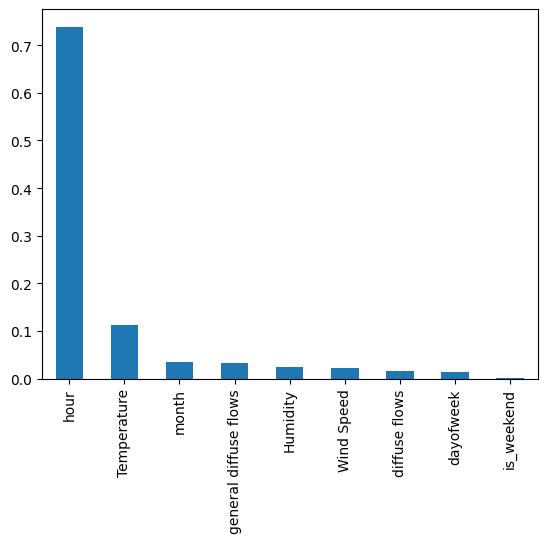

In [187]:
model = RandomForestRegressor().fit(x_final, y)
# Get feature importance
importance = pd.Series(model.feature_importances_, index=x_final.columns)
importance.sort_values(ascending=False).plot(kind='bar')


In [188]:
low_importance = importance[importance < 0.01].index.tolist()
print("Drop these features:", low_importance)


Drop these features: ['is_weekend']


Text(0.5, 1.0, 'Feature Importances with Drop Threshold')

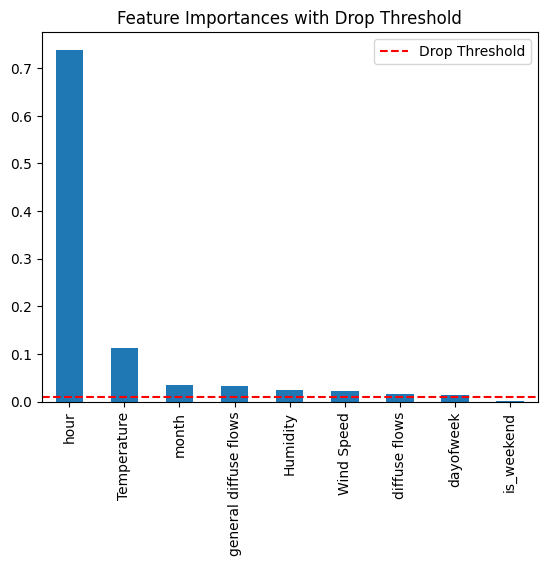

In [189]:
importance.sort_values(ascending=False).plot(kind='bar')
plt.axhline(0.01, color='red', linestyle='--', label='Drop Threshold')
plt.legend()
plt.title("Feature Importances with Drop Threshold")


In [195]:
x_final.drop(columns="is_weekend", inplace=True)

- ##### **6.2: Tuning with Cross Validation**
- GridSearchCV is the better way to combine cross-validation + tuning and that is powerful workflow. not separately find cross validation score and then perform tuning.

In [196]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, KFold

dtr1 = DecisionTreeRegressor(random_state=42)
param_grid = {
    'max_depth': [3, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_leaf_nodes': [None, 10, 20, 30]
}
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=dtr1,
                           param_grid=param_grid,
                           cv=kf,
                           scoring='r2',
                           n_jobs=-1,     # Use all available cores
                           verbose=1)     # Show progress

grid_search.fit(x_final, y)

# Best hyperparameters and R² score
print("✅ Best Hyperparameters:", grid_search.best_params_)
print("✅ Best Cross-Validated R² Score:", grid_search.best_score_)
best_tree = grid_search.best_estimator_


Fitting 5 folds for each of 320 candidates, totalling 1600 fits
✅ Best Hyperparameters: {'max_depth': 20, 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
✅ Best Cross-Validated R² Score: 0.944684062352151


In [197]:
x_train,x_test,y_train,y_test = train_test_split(x_final,y, test_size=0.20, random_state=42)

In [198]:
dtr2 = DecisionTreeRegressor(max_depth= 20, max_leaf_nodes= None, min_samples_leaf= 2, min_samples_split= 5)
dtr2.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=5)

In [199]:
dtr2.score(x_test, y_test)*100

94.2842383754074

In [200]:
dtr2.score(x_train,y_train)*100

99.16661449237262

- ##### **6.3: Ensemble Techniques**

In [201]:
# Cross validation(GridSearchCV) + Tuning for RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold

# Base Random Forest model
rf = RandomForestRegressor(random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],              # Number of trees in the forest
    'max_depth': [5, 10, 15],                # Depth of each tree
    'min_samples_split': [2, 5, 10],         # Minimum samples to split
    'min_samples_leaf': [1, 2, 5],           # Minimum samples in leaf
    'max_features': ['sqrt', 'log2']         # Features per split
}

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search with R² scoring
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=kf,
                           scoring='r2',
                           n_jobs=-1,
                           verbose=1)

# Fit the model
grid_search.fit(x_final, y)

# Output best results
print("✅ Best Hyperparameters (Random Forest):", grid_search.best_params_)
print("✅ Best Cross-Validated R² Score:", grid_search.best_score_)

# Best model after tuning
best_rf = grid_search.best_estimator_


Fitting 5 folds for each of 108 candidates, totalling 540 fits


KeyboardInterrupt: 

In [202]:
rfr = RandomForestRegressor()
rfr.fit(x_train, y_train)

RandomForestRegressor()

In [203]:
rfr.score(x_test, y_test)*100

97.2731977305879

In [204]:
rfr.score(x_train, y_train)*100

99.5964076564098